# Bitcoin Price Prediction: Linear Regression Implementation
This notebook outlines the implementation of a linear regression for bitcoin price prediction. This method was implemented as baseline model to compare more sophisticated models against, both in terms of performance and energy consumption. CodeCarbon will be implemented in every modelling notebook to compare environmental costs.

## The Dataset ##
Produced in the first assignment, two datasets were created:
1.  A long-term dataset consisting of various Bitcoin (BTC) close prices and close prices of various other stocks/ETFs.
2. A short-term dataset consisting of the same data as above but also include Twitter Sentinement Scores towards BTC using VADER Sentiment Extractor.

Various BTC Close prices were extracted due to conflictions within various data extraction methods. This project will explore Close_UTC_00 as the target.

## Note: Dealing with multicollinearity
As mentioned in the first report, high VIF scores between S&P 500 ETF Trust and Apple and Coinbase indicated multicollinearity. For Linear Regression, it assumes that the target variable is some linear combination of multiple independent predictors. Therefore this multicollinearity must be addresed.  Dropping S&P 500 ETF Trust reduced the VIF to an acceptable amount and so three experiments were devised:
1. `X = Close Price BTC, Y = Sentiment Scores, Close Apple, Close Coinbase`
2. `X = Close Price BTC, Y = Sentiment Scoress, Close SPDR S&P 500 ETF Trust`
3. `X = Close Price BTC, Y = Sentiment Scores, PCA(Close Apple, Close Coinbase, Close SPDR S&P 500 ETF Trust)`

Principal Components Analysis will be used to reduced the dimensionality and correlation between the stock predictors. Adding Lag features also raises corerelation concerns and are addressed throughout the notebook.

**Note** The values were already scaled using a min-max scaler, they must be rescaled for PCA using a z-score scaler to capture the variance needed for PCA.

Performance will measured by comparing Mean Absolute Error, Root Mean Squared Error and Symmetric Mean Absolute Percentage Error. AIC, BIC and R^2 will also be used to determine the best mix of predictors. As mentioned in the report, these functions were saved in a separate .py file and loaded in for evaluation.

As RSI and lagged features were added to the dataset, VIF will be used to determine any further Multicollinearity other than the ones already listed above. While most of the other models can deal with mutlicolinearity, it is still important to note and to deal with in linear models such as the model here.
Once the best model and variables are selected, Regularized Regression will be explored to prevent overfitting. Rolling CV will also be used to avoid time leakage. This function is included in the separate py file for convenience and reuse.

Once the Regularized Regression parameters have been tuned, the full final model will be tested with CodeCarbon to extract energy usage information.

For a fair comparison with the other models, the Regularized model will be fit on all the same predictors as the other models, with the idea that the regularization shoudl combat some of the multicolinearity.

Resources Used:
*  [Code Carbon Documentation](https://mlco2.github.io/codecarbon/)
*  [Linear Regression Bitcoin Implementation Resource](https://github.com/cipher813/bitcoin_prediction/blob/master/20180202_Bitcoin_LR_Presentation.pdf)
*  [Rolling Window CV Implementation](https://subashpalvel.medium.com/understanding-time-series-cross-validation-1929c543d339)
* [Information about Understanding the model summary](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a)
*  [Fitting Regularized Fit to prevent overfitting](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html)


In [ ]:
#Installations
!pip install optuna
!pip install codecarbon

In [ ]:
# Imports
from codecarbon import EmissionsTracker
tracker = EmissionsTracker(
    output_file='emissions_lin_reg.csv',
    project_name='lin_reg_implementation') #,country_iso_code="IE"
tracker.start()

# neccessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna
from google.colab import drive
from google.colab import files
import sys
import joblib
import zipfile

#setting seed for reproducibility
np.random.seed(42)

#mount
drive.mount('/content/drive', force_remount=True)

#copy this file to the Colab Directory - alternatively: just download and upload directly
!cp '/content/drive/MyDrive/Semester 2/Advanced Machine Learning/Assignment 2/eval_metrics_cv.py' . #replace FILE_PATH with actual file path.
# Add the directory containing eval_metrics.py to the system path
sys.path.append('.')

# Evaluations py file
from eval_metrics_cv import mae_calc, rmse_calc, smape_calc, rolling_cv
#loading datasets
file_path_1 = '/content/drive/MyDrive/Semester 2/Advanced Machine Learning/Assignment 2/feature_engineered_data_1.csv'
file_path_2 = '/content/drive/MyDrive/Semester 2/Advanced Machine Learning/Assignment 2/feature_engineered_data_2.csv'

df_1 = pd.read_csv(file_path_1)
df_2 = pd.read_csv(file_path_2)

[codecarbon WARNING @ 23:48:26] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:48:26] [setup] RAM Tracking...
[codecarbon INFO @ 23:48:26] [setup] CPU Tracking...
[codecarbon WARNING @ 23:48:27] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 23:48:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 23:48:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 23:48:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:48:27] [setup] GPU Tracking...
[codecarbon INFO @ 23:48:27] No GPU found.
[codecarbon INFO @ 23:48:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Mounted at /content/drive


In [ ]:
#splitting the data, 90% training model and tuning, 5% test and refit, 5% for later final meta evaluation

#df_1
total_df_1_len = len(df_1)
train_df_1_len = int(0.9 * total_df_1_len)
refit_df_1_len = int(0.05 * total_df_1_len)
meta_df_1_len = int(0.05 * total_df_1_len)

#creating splits
train_df_1 = df_1.iloc[:train_df_1_len]
refit_df_1 = df_1.iloc[train_df_1_len:train_df_1_len + refit_df_1_len]
meta_df_1 = df_1.iloc[train_df_1_len + refit_df_1_len:]

#df_2
total_df_2_len = len(df_2)
train_df_2_len = int(0.9 * total_df_2_len)
refit_df_2_len = int(0.05 * total_df_2_len)
meta_df_2_len = int(0.05 * total_df_2_len)

#creating splits
train_df_2 = df_2.iloc[:train_df_2_len]
refit_df_2 = df_2.iloc[train_df_2_len:train_df_2_len + refit_df_2_len]
meta_df_2 = df_2.iloc[train_df_2_len + refit_df_2_len:]

## Using VIF to investigate Multicollinarity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
features_d1 = df_1[['Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI', 'Close_UTC_00_lag1', 	'Close_UTC_00_lag3', 	'Close_UTC_00_lag7', 	'RSI_lag1', 	'RSI_lag3', 	'RSI_lag7', 	'YEAR',	'MONTH',	'DAY']]

features_d2 = df_2[[ 'avg_sentiment_score', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI', 'Close_UTC_00_lag1', 	'Close_UTC_00_lag3', 	'Close_UTC_00_lag7', 	'RSI_lag1', 	'RSI_lag3', 	'RSI_lag7', 	'YEAR',	'MONTH',	'DAY']]

X1 = sm.add_constant(features_d1)
X2 = sm.add_constant(features_d2)


vif_data_1 = pd.DataFrame()
vif_data_1["Feature"] = X1.columns
vif_data_1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif_data_1



,Feature,VIF
0,const,3.853567e+07
1,Close Value Apple,6.270466e+00
2,Close Value SPDR S&P 500 ETF Trust,2.934801e+01
3,Close Value Coinbase,1.562432e+01
4,RSI,6.801404e+00
5,Close_UTC_00_lag1,1.946930e+02
6,Close_UTC_00_lag3,2.532848e+02
7,Close_UTC_00_lag7,9.439925e+01
8,RSI_lag1,1.135256e+01
9,RSI_lag3,7.374171e+00


In [ ]:

vif_data_2 = pd.DataFrame()
vif_data_2["Feature"] = X2.columns
vif_data_2["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif_data_2

,Feature,VIF
0,avg_sentiment_score,2.331957
1,Close Value Apple,26.287332
2,Close Value SPDR S&P 500 ETF Trust,20.931671
3,Close Value Coinbase,27.741042
4,RSI,6.573868
5,Close_UTC_00_lag1,46.477364
6,Close_UTC_00_lag3,43.135683
7,Close_UTC_00_lag7,17.507156
8,RSI_lag1,11.770353
9,RSI_lag3,9.015106


## Discussion
Based on the results above there is a high level of collinearity between predictors. The following methods will be explored:
*  Combine or drop some of the lag features as they are likely colinear.
*  Check if this reduces the high VIF for YEAR, if not drop YEAR
*  PCA on the Stock Data as discussed above
*  Compare results from including different combinations of stocks as discussed above
*  Employ a Ridge/Lasso Regression model that will penalize/remove features that are unhelpful


### Creating Mean Lag Features for BTC Close and RSI

In [ ]:
df_1['Close_UTC__00_mean_lag']= df_1[['Close_UTC_00_lag1', 'Close_UTC_00_lag3', 'Close_UTC_00_lag7']].mean(axis=1)
df_1['RSI_mean_lag']= df_1[['RSI_lag1', 'RSI_lag3', 'RSI_lag7']].mean(axis=1)

df_2['Close_UTC__00_mean_lag']= df_2[['Close_UTC_00_lag1', 'Close_UTC_00_lag3', 'Close_UTC_00_lag7']].mean(axis=1)
df_2['RSI_mean_lag']= df_2[['RSI_lag1', 'RSI_lag3', 'RSI_lag7']].mean(axis=1)

In [ ]:
#Recheck VIF with new mean lags
features_d1 = df_1[['Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI', 'Close_UTC__00_mean_lag', 'RSI_mean_lag', 'YEAR',	'MONTH',	'DAY']]


X1 = sm.add_constant(features_d1)


vif_data_1 = pd.DataFrame()
vif_data_1["Feature"] = X1.columns
vif_data_1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif_data_1



,Feature,VIF
0,const,3.785226e+07
1,Close Value Apple,6.253044e+00
2,Close Value SPDR S&P 500 ETF Trust,2.921899e+01
3,Close Value Coinbase,1.513728e+01
4,RSI,3.119711e+00
5,Close_UTC__00_mean_lag,2.055968e+01
6,RSI_mean_lag,3.182174e+00
7,YEAR,5.729131e+00
8,MONTH,1.468721e+00
9,DAY,1.004904e+00


In [ ]:
#Recheck VIF with new mean lags
features_d1 = df_1[[ 'RSI', 'Close_UTC__00_mean_lag', 'RSI_mean_lag', 'YEAR',	'MONTH',	'DAY']]


X1 = sm.add_constant(features_d1)

vif_data_1 = pd.DataFrame()
vif_data_1["Feature"] = X1.columns
vif_data_1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif_data_1



,Feature,VIF
0,const,1.434010e+07
1,RSI,2.951958e+00
2,Close_UTC__00_mean_lag,2.164195e+00
3,RSI_mean_lag,2.946562e+00
4,YEAR,2.170390e+00
5,MONTH,1.071037e+00
6,DAY,1.004355e+00


In [ ]:
#Recheck VIF with new mean lags
features_d2 = df_2[['avg_sentiment_score','Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI', 'Close_UTC__00_mean_lag', 'RSI_mean_lag', 'YEAR',	'MONTH',	'DAY']]


X2 = sm.add_constant(features_d2)


vif_data_2 = pd.DataFrame()
vif_data_2["Feature"] = X2.columns
vif_data_2["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif_data_2



,Feature,VIF
0,avg_sentiment_score,2.176510
1,Close Value Apple,25.638482
2,Close Value SPDR S&P 500 ETF Trust,19.897531
3,Close Value Coinbase,26.406632
4,RSI,3.031314
5,Close_UTC__00_mean_lag,9.062329
6,RSI_mean_lag,4.350551
7,YEAR,168.069790
8,MONTH,12.054754
9,DAY,1.388886


In [ ]:
#Recheck VIF with new mean lags
features_d2 = df_2[['avg_sentiment_score', 'RSI', 'Close_UTC__00_mean_lag', 'RSI_mean_lag', 'YEAR'	,'MONTH',	'DAY']]


X2 = sm.add_constant(features_d2)
#X2 = sm.add_constant(features_d2)


vif_data_2 = pd.DataFrame()
vif_data_2["Feature"] = X2.columns
vif_data_2["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif_data_2



,Feature,VIF
0,avg_sentiment_score,1.815688
1,RSI,2.419279
2,Close_UTC__00_mean_lag,5.098010
3,RSI_mean_lag,3.452675
4,YEAR,89.297657
5,MONTH,2.565968
6,DAY,1.258856


From this it can be seen that the mean lag of the BTC Close price causes the VIF to be slightly too high when combined with any other stocks.
Therefore it will only be included when the Close values of the other stocks are combined using PCA. Therefore the plan is now extended to include:
*  Just Temporal and Close lage features (RSI, CLOSELAG, RSIMEAN, YEAR, MONTH, DAY)
*  Influences of Other stocks + time without close lag(RSI, APPLE, COINBASE, RSIMEAN, YEAR, MONTH, DAY) AND (RSI, S&P ETF, RSIMEAN, YEAR, MONTH, DAY)
*  PCA with all stocks and all other features
*  Ridge Regression with all features without PCA

For the smaller dataset, it appears that YEAR has an even higher VIF and that the stocks whenever combined have a high VIF. Therefore they will only be tried using PCA and checked how the Temporal features change with resepect to these reduced variables, with YEAR being excluded if needed. All featured will be given to a RIDGE Regression model.

**Note**: A Multicollinearity warning was consistent whenever YEAR was present so therefore it was removed from all models for further studies.

In [ ]:
#PCA on STOCK for df_1 and df_2
corr_feats_df_1 = df_1[['Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase']]
corr_feats_df_2 = df_2[['Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase']]

#scaling and perfroming pca on correlated features
scaler = StandardScaler()

#df 1
corr_feats_scaled_1 = scaler.fit_transform(corr_feats_df_1)
pca = PCA(n_components=2)
feats_pca_df_1 = pca.fit_transform(corr_feats_scaled_1)


#df 2
corr_feats_scaled_2 = scaler.fit_transform(corr_feats_df_2)
pca = PCA(n_components=2)
feats_pca_df_2 = pca.fit_transform(corr_feats_scaled_2)

## Dataset 1: Temporal Features Only

In [ ]:
y1 = df_1['Close_UTC_00']
X1 = df_1[['RSI', 'Close_UTC__00_mean_lag', 'RSI_mean_lag',	'MONTH',	'DAY']]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y1, X1).fit()
print("\nModel 1: Relative Strength Index, Lags and Time Information")
print(model1.summary())


Model 1: Relative Strength Index, Lags and Time Information
                            OLS Regression Results                            
Dep. Variable:           Close_UTC_00   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.305e+04
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:49:03   Log-Likelihood:                 2373.8
No. Observations:                 983   AIC:                            -4736.
Df Residuals:                     977   BIC:                            -4706.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [ ]:
#using the eval metrics and rolling cv from eval metrics.py
y1 = df_1['Close_UTC_00']
X1 = df_1[['RSI', 'Close_UTC__00_mean_lag', 'RSI_mean_lag', 'MONTH',	'DAY']]
y = y1.values
X = X1.values

# 5 Fold Cross Validation
cv_results = rolling_cv(
    X=X,
    y=y,
    model=sm.OLS,
    model_type='statsmodel',
    n_splits=5,
    return_preds=True
)

#Printing the results
print("\nCross-Validation Results:")
print(f"MAE: {cv_results['mae']:.4f}")
print(f"RMSE: {cv_results['rmse']:.4f}")
print(f"SMAPE: {cv_results['smape']:.2f}%")


Cross-Validation Results:
MAE: 0.0170
RMSE: 0.0224
SMAPE: 16.99%


## Dataset 1: All Features Close Lag and S&P Stock

In [ ]:
y2 = df_1['Close_UTC_00']
X2 = df_1[['RSI', 'Close Value Apple', 'Close Value Coinbase', 'RSI_mean_lag',	'MONTH',	'DAY']]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y2, X2).fit()
print("\nModel 1: All Features except Close Lag and S&P 500 ETF")
print(model2.summary())


Model 1: All Features except Close Lag and S&P 500 ETF
                            OLS Regression Results                            
Dep. Variable:           Close_UTC_00   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1627.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:49:03   Log-Likelihood:                 1027.7
No. Observations:                 983   AIC:                            -2041.
Df Residuals:                     976   BIC:                            -2007.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [ ]:
#using the eval metrics and rolling cv from eval metrics.py

y = y2.values
X = X2.values

# 5 Fold Cross Validation
cv_results = rolling_cv(
    X=X,
    y=y,
    model=sm.OLS,
    model_type='statsmodel',
    n_splits=5,
    return_preds=True
)

#Printing the results
print("\nCross-Validation Results Model 2:")
print(f"MAE: {cv_results['mae']:.4f}")
print(f"RMSE: {cv_results['rmse']:.4f}")
print(f"SMAPE: {cv_results['smape']:.2f}%")


Cross-Validation Results Model 2:
MAE: 0.1471
RMSE: 0.1647
SMAPE: 57.18%


## Dataset 1: All Features Close Lag and Coinbase and Apple Stock

In [ ]:
y3 = df_1['Close_UTC_00']
X3 = df_1[['RSI', 'Close Value SPDR S&P 500 ETF Trust', 'RSI_mean_lag',	'MONTH',	'DAY']]
X3 = sm.add_constant(X3)
model3 = sm.OLS(y3, X3).fit()
print("\nModel 3: All Features except Close Lag, Coinbase and Apple")
print(model3.summary())


Model 3: All Features except Close Lag, Coinbase and Apple
                            OLS Regression Results                            
Dep. Variable:           Close_UTC_00   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1390.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:49:03   Log-Likelihood:                 878.16
No. Observations:                 983   AIC:                            -1744.
Df Residuals:                     977   BIC:                            -1715.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [ ]:
#using the eval metrics and rolling cv from eval metrics.py

y = y3.values
X = X3.values

# 5 Fold Cross Validation
cv_results = rolling_cv(
    X=X,
    y=y,
    model=sm.OLS,
    model_type='statsmodel',
    n_splits=5,
    return_preds=True
)

#Printing the results
print("\nCross-Validation Results Model 3:")
print(f"MAE: {cv_results['mae']:.4f}")
print(f"RMSE: {cv_results['rmse']:.4f}")
print(f"SMAPE: {cv_results['smape']:.2f}%")


Cross-Validation Results Model 3:
MAE: 0.1412
RMSE: 0.1627
SMAPE: 56.73%


## Dataset 1: PCA of Stocks with all other features

In [ ]:
#create pca features
non_pca_features = df_1[['RSI', 'Close_UTC__00_mean_lag', 'RSI_mean_lag',	'MONTH',	'DAY']]
pca_features = pd.DataFrame({
    'pca1': feats_pca_df_1[:, 0],
    'pca2': feats_pca_df_1[:, 1]
}, index=df_1.index)

#combine
X4 = pd.concat([non_pca_features, pca_features], axis=1)
X4.head()

,RSI,Close_UTC__00_mean_lag,RSI_mean_lag,MONTH,DAY,pca1,pca2
0,0.172559,0.509309,0.188820,1,8,1.146712,1.162402
1,0.150561,0.507308,0.523290,1,9,1.146712,1.162402
2,0.265888,0.482598,0.335909,1,10,1.081219,1.085924
3,0.255382,0.477645,0.303377,1,11,1.297336,1.126122
4,0.333373,0.464355,0.250497,1,12,1.302058,1.086281


In [ ]:
X4 = sm.add_constant(X4)
y4 = df_1['Close_UTC_00']

model4 = sm.OLS(y4, X4).fit()
print("\nModel 4: PCA of Stocks with all other features")
print(model4.summary())


Model 4: PCA of Stocks with all other features
                            OLS Regression Results                            
Dep. Variable:           Close_UTC_00   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 2.494e+04
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:49:03   Log-Likelihood:                 2401.6
No. Observations:                 983   AIC:                            -4787.
Df Residuals:                     975   BIC:                            -4748.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
#using the eval metrics and rolling cv from eval metrics cv.py

y = y4.values
X = X4.values

# 5 Fold Cross Validation
cv_results = rolling_cv(
    X=X,
    y=y,
    model=sm.OLS,
    model_type='statsmodel',
    n_splits=5,
    return_preds=True
)

#Printing the results
print("\nCross-Validation Results Model 4:")
print(f"MAE: {cv_results['mae']:.4f}")
print(f"RMSE: {cv_results['rmse']:.4f}")
print(f"SMAPE: {cv_results['smape']:.2f}%")


Cross-Validation Results Model 4:
MAE: 0.0270
RMSE: 0.0327
SMAPE: 21.39%


## Discussion
From these results we can see that the P statistic indicates that RSI and Day are not good predictors for Close UTC BTC Price. It can also be seen that the R^2 results claims very high values such as 0.994 for the temporal and pca models, likely indicating overfitting.

Therefore Regularization will be explored to compensate for this. Regularized Regression was chosen, due to its ability to heavily penalize irrelevant features and potentially balance between Lasso and Ridge Regression. Hyperparameter tuning will then be explored to maximise the ability of this regularized model. Year will still be removed.

# Regularized Regression with all Features and Hyperparameter Tuning

###Implemenation with Other Variable Combination
```
#statsmodels.regression.linear_model.OLS.fit_regularized
X_full = df_1[['RSI', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'Close_UTC__00_mean_lag', 'RSI_mean_lag',	'MONTH',	'DAY']]
y_full = df_1['Close_UTC_00']
X_full = sm.add_constant(X_full)

model_full = sm.OLS(y_full, X_full).fit_regularized(method='elastic_net', alpha=0.05, L1_wt=0 )#refit=True
print("\nModel Regularized: All Features with Ridge Regularization")
print(model_full.params)
```

In [ ]:
#statsmodels.regression.linear_model.OLS.fit_regularized
features = [ 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']
target = 'Close_UTC_00'

X_train = train_df_1[features]
y_train = train_df_1[target]
X_test = refit_df_1[features]
y_test = refit_df_1[target]


X_train = sm.add_constant(X_train)

model_full = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=0.05, L1_wt=0 )#refit=True
print("\nModel Regularized: All Features with Ridge Regularization")
print(model_full.params)


Model Regularized: All Features with Ridge Regularization
[ 8.72540800e-03  4.83043789e-02  1.27400328e-01  1.58455179e-01
  3.15058173e-02  1.93525712e-01  1.87685327e-01  1.80906207e-01
  2.30718507e-02  1.59342406e-02  9.90810630e-03 -5.12921622e-03
  1.23887851e-04]


As the fit is different to the way the rolling_cv handles the usual Linear Regression, it was decided to call the regularized version as a 'custom' model and create custom_fit and custom_predict functions for the rolling_cv

In [ ]:
#fit function
def ridge_fit(model_dict, X_train, y_train, alpha=0.05, L1_wt=0):
  X_train_const = sm.add_constant(X_train, has_constant='add')
  model_fit = sm.OLS(y_train, X_train_const).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=L1_wt)
  model_dict['model'] = model_fit
  model_dict['params'] = model_fit.params
  model_dict['X_columns'] = X_train_const.shape[1] #useful for possible shape issues
  return model_dict

#predict function
def ridge_predict(model_dict, X_test):
  X_test_const = sm.add_constant(X_test, has_constant='add')
  model = model_dict['model']
  return model.predict(X_test_const)

In [ ]:
#using the eval metrics and rolling cv from eval metrics.py
alpha = 0.05
L1_wt = 0
y = y_train.values
X = X_train.values
# 5 Fold Cross Validation
cv_results = rolling_cv(
    X=X,
    y=y,
    model={}, #saved as dictionary
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: ridge_fit(model, X_train, y_train, alpha=alpha, L1_wt=L1_wt),
    custom_predict = ridge_predict,
    return_preds=True
)

#Printing the results
print("\nCross-Validation Results Model 4:")
print(f"MAE: {cv_results['mae']:.4f}")
print(f"RMSE: {cv_results['rmse']:.4f}")
print(f"SMAPE: {cv_results['smape']:.2f}%")


Cross-Validation Results Model 4:
MAE: 0.1184
RMSE: 0.1333
SMAPE: 55.54%


## Hyperparameter Tuning
Optuna was chosen to determine the optimal Hyperparameters. It provides an efficient way to create a grid over which to determine the best parameters. In this instance, it will also be used to decide whether Ridge, Lasso or something in between would work best in terms of regularization (L1_wt), where 0 is Ridge and 1 is Lasso.

Resource:
* [Documentation](https://optuna.org/)
* [Hugging Face Guide](https://huggingface.co/docs/transformers/hpo_train)


In [ ]:
#param tuner
def objective(trial):
  alpha = trial.suggest_float('alpha', 0.001, 0.1, log=True)
  L1_wt = trial.suggest_float('L1_wt', 0, 1)

  cv_results = rolling_cv(
    X=X,#defined above
    y=y,
    model={}, #saved as dictionary
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: ridge_fit(model, X_train, y_train, alpha=alpha, L1_wt=L1_wt),
    custom_predict = ridge_predict,
    return_preds=False #memory saving during trial
  )
  return cv_results['rmse']

#initialising
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-04-19 23:49:04,125] A new study created in memory with name: no-name-eef3a3ee-03f4-45cd-b2e9-5269a174c18d
[I 2025-04-19 23:49:04,701] Trial 0 finished with value: 0.07035559938466471 and parameters: {'alpha': 0.0010769469085768273, 'L1_wt': 0.6104056622771349}. Best is trial 0 with value: 0.07035559938466471.
[I 2025-04-19 23:49:05,017] Trial 1 finished with value: 0.23255649299029976 and parameters: {'alpha': 0.034522747359485705, 'L1_wt': 0.5654762286329205}. Best is trial 0 with value: 0.07035559938466471.
[I 2025-04-19 23:49:06,070] Trial 2 finished with value: 0.06840187476832572 and parameters: {'alpha': 0.004700457853959319, 'L1_wt': 0.01827390091152392}. Best is trial 2 with value: 0.06840187476832572.
[I 2025-04-19 23:49:06,843] Trial 3 finished with value: 0.08893852119482193 and parameters: {'alpha': 0.0021106048064970483, 'L1_wt': 0.9052982572720824}. Best is trial 2 with value: 0.06840187476832572.
[I 2025-04-19 23:49:06,948] Trial 4 finished with value: 0.32304933

Best Hyperparameters: {'alpha': 0.0013606286951732894, 'L1_wt': 0.008654440421484331}


In [ ]:
#fitting best model
alpha = best_params['alpha']
L1_wt = best_params['L1_wt']

#using test set or refit
X = X_test.values
y = y_test.values
X = sm.add_constant(X, has_constant='add')
model_best = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=L1_wt)
print("\nModel Regularized: All Features with Regularization & Tuning")


Model Regularized: All Features with Regularization & Tuning


In [ ]:
print(model_best.params)

[ 0.81616631 -0.05650895  0.06524809  0.13465936  0.08965958  0.02020396
 -0.01670011 -0.02307001  0.01521553  0.05746045  0.10418878 -0.03554302
  0.00096077]


In [ ]:
#save best model
joblib.dump(model_best, 'best_model_df_1.pkl')

['best_model_df_1.pkl']

In [ ]:
results = {
    "mae": cv_results['mae'],
    "rmse": cv_results['rmse'],
    "smape": cv_results['smape'],
    "best_params": best_params,
    "best_model": model_best
}

#save to csv
results_df = pd.DataFrame(results)
results_df.to_csv('results_df_1.csv', index=False)

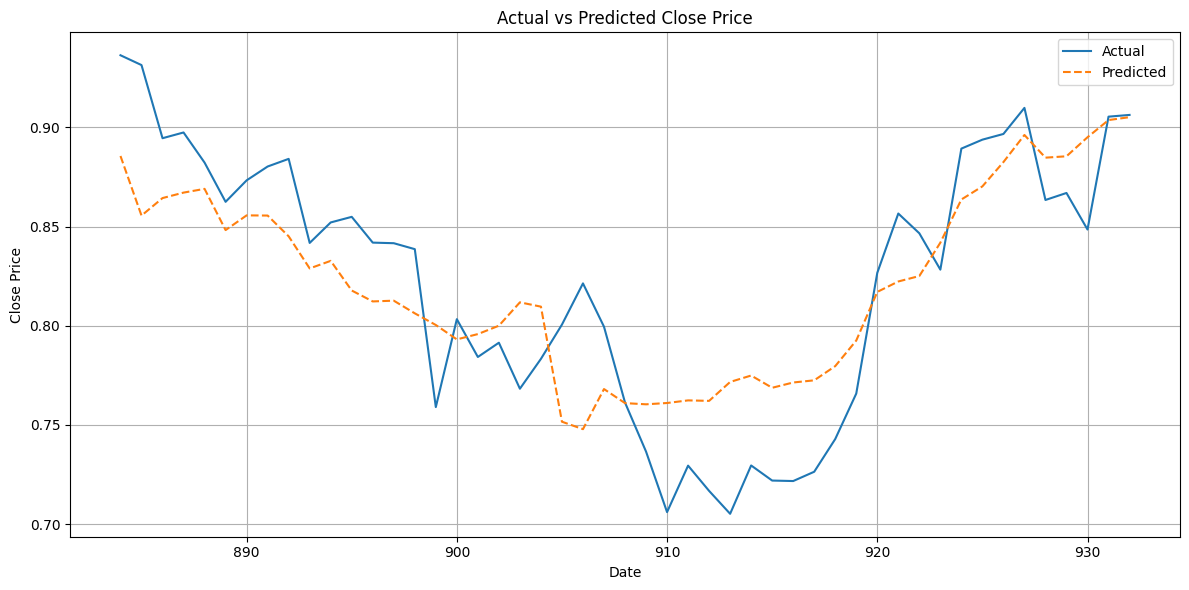

<Figure size 640x480 with 0 Axes>

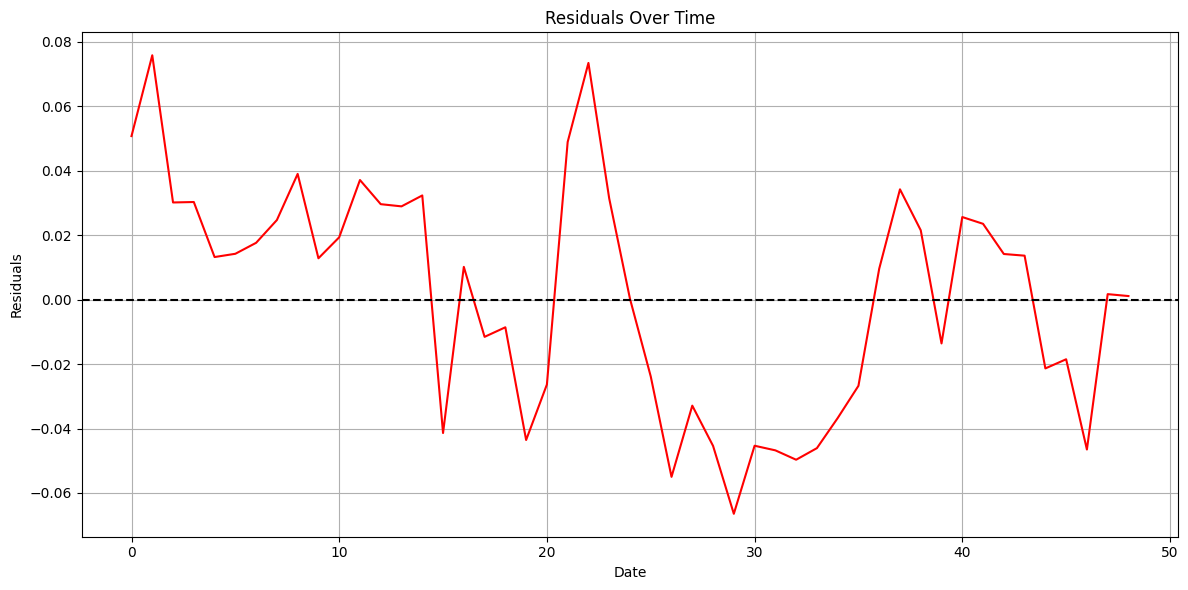

<Figure size 640x480 with 0 Axes>

In [ ]:
#predicting using the trained model
y_pred = model_best.predict(X)

#plot
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y, label='Actual', )
plt.plot(X_test.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#save image
plt.savefig('actual_vs_predicted_df_1.png')

#residuals
residuals = y - y_pred
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('residuals_df_1.png')


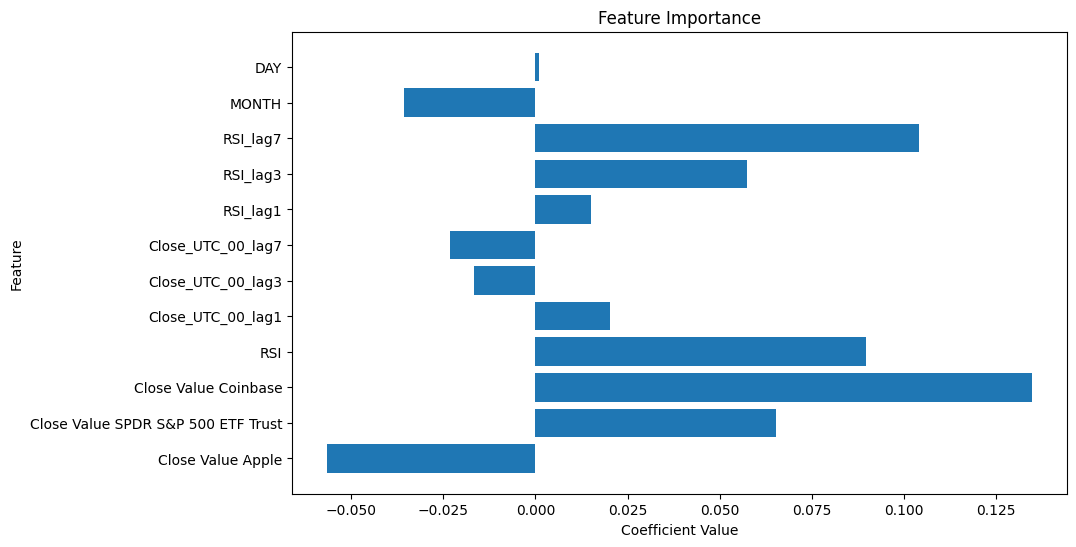

<Figure size 640x480 with 0 Axes>

In [ ]:
#feature importance
feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': model_best.params[1:]
})

#plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()
plt.savefig('feature_importance_df_1.png')

It was decided to do this approach also for df_2.

### Eearlier Implemenation with different variables
```
#statsmodels.regression.linear_model.OLS.fit_regularized
X_full_2 = df_2[['avg_sentiment_score', 'RSI', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'Close_UTC__00_mean_lag', 'RSI_mean_lag',	'MONTH',	'DAY']]
y_full_2 = df_2['Close_UTC_00']
X_full_2 = sm.add_constant(X_full_2)

model_full = sm.OLS(y_full_2, X_full_2).fit_regularized(method='elastic_net', alpha=0.05, L1_wt=0 )#refit=True
print("\nModel Regularized: All Features with Ridge Regularization")
print(model_full.params)
```

In [ ]:
#statsmodels.regression.linear_model.OLS.fit_regularized
features = ['avg_sentiment_score' ,'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']
target = 'Close_UTC_00'

X_train = train_df_2[features]
y_train = train_df_2[target]
X_test = refit_df_2[features]
y_test = refit_df_2[target]

X_train = sm.add_constant(X_train)

model_full = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=0.05, L1_wt=0 )#refit=True
print("\nModel Regularized: All Features with Ridge Regularization")
print(model_full.params)


Model Regularized: All Features with Ridge Regularization
[0.08097831 0.02978647 0.07134915 0.06342851 0.11671216 0.05760951
 0.08218351 0.07671528 0.07190037 0.0440239  0.03768372 0.03227037
 0.00364933 0.00075893]


As the fit is different to the way the rolling_cv handles the usual Linear Regression, it was decided to call the regularized version as a 'custom' model and create custom_fit and custom_predict functions for the rolling_cv

In [ ]:
#using the eval metrics and rolling cv from eval metrics.py
alpha = 0.05
L1_wt = 0
y = y_train.values
X = X_train.values
# 5 Fold Cross Validation
cv_results = rolling_cv(
    X=X,
    y=y,
    model={}, #saved as dictionary
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: ridge_fit(model, X_train, y_train, alpha=alpha, L1_wt=L1_wt),
    custom_predict = ridge_predict,
    return_preds=True
)

#Printing the results
print("\nCross-Validation Results Model 4:")
print(f"MAE: {cv_results['mae']:.4f}")
print(f"RMSE: {cv_results['rmse']:.4f}")
print(f"SMAPE: {cv_results['smape']:.2f}%")


Cross-Validation Results Model 4:
MAE: 0.0665
RMSE: 0.0725
SMAPE: 18.78%


## Hyperparameter Tuning



In [ ]:
#param tuner
def objective(trial):
  alpha = trial.suggest_float('alpha', 0.001, 0.1, log=True)
  L1_wt = trial.suggest_float('L1_wt', 0, 1)

  cv_results = rolling_cv(
    X=X,
    y=y,
    model={}, #saved as dictionary
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: ridge_fit(model, X_train, y_train, alpha=alpha, L1_wt=L1_wt),
    custom_predict = ridge_predict,
    return_preds=False #memory saving during trial
  )
  return cv_results['rmse']

#initialising
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params_2 = study.best_params
print("Best Hyperparameters:", best_params_2)

[I 2025-04-19 23:52:57,303] A new study created in memory with name: no-name-2406c83b-1d01-4bcd-8087-5b9cf11c4c47
[I 2025-04-19 23:52:57,848] Trial 0 finished with value: 0.09877284460518096 and parameters: {'alpha': 0.013339391180712165, 'L1_wt': 0.5685699374687831}. Best is trial 0 with value: 0.09877284460518096.
[codecarbon INFO @ 23:52:58] Energy consumed for RAM : 0.000750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:52:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:52:58] Energy consumed for All CPU : 0.003188 kWh
[codecarbon INFO @ 23:52:58] 0.003938 kWh of electricity used since the beginning.
[I 2025-04-19 23:52:58,412] Trial 1 finished with value: 0.08581262398732922 and parameters: {'alpha': 0.021710042428117984, 'L1_wt': 0.2426372896416199}. Best is trial 1 with value: 0.08581262398732922.
[I 2025-04-19 23:52:58,754] Trial 2 finished with value: 0.13900767979287304 and parameters: {'alpha': 0.0285589003722502, 'L1_wt':

Best Hyperparameters: {'alpha': 0.0015214621742920226, 'L1_wt': 0.9207474949747072}


## Non-correlated version
```
#fitting best model
alpha = best_params_2['alpha']
L1_wt = best_params_2['L1_wt']

X_2 = df_2[['avg_sentiment_score','RSI', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'Close_UTC__00_mean_lag', 'RSI_mean_lag',	'MONTH',	'DAY']]
y_2 = df_2['Close_UTC_00']
X_2 = sm.add_constant(X_2, has_constant='add')
model_best_2 = sm.OLS(y_2, X_2).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=L1_wt)
print("\nModel Regularized: All Features with Regularization & Tuning")
```

In [ ]:
#fitting best model
alpha = best_params_2['alpha']
L1_wt = best_params_2['L1_wt']

X_2 = X_test
y_2 = y_test
X_2 = sm.add_constant(X_2, has_constant='add')
model_best_2 = sm.OLS(y_2, X_2).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=L1_wt)
print("\nModel Regularized: All Features with Regularization & Tuning")


Model Regularized: All Features with Regularization & Tuning


In [ ]:
results = {
    "mae": cv_results['mae'],
    "rmse": cv_results['rmse'],
    "smape": cv_results['smape'],
    "best_params": best_params_2,
    "best_model": model_best_2
}

#save to csv
results_df = pd.DataFrame(results)
results_df.to_csv('results_df_2.csv', index=False)

In [ ]:
print(model_best_2.params)

const                                 0.114365
avg_sentiment_score                   0.000000
Close Value Apple                     0.000000
Close Value SPDR S&P 500 ETF Trust    0.000000
Close Value Coinbase                  0.000000
RSI                                   0.098252
Close_UTC_00_lag1                     0.000000
Close_UTC_00_lag3                     0.000000
Close_UTC_00_lag7                     0.000000
RSI_lag1                              0.104077
RSI_lag3                              0.000000
RSI_lag7                              0.000000
MONTH                                 0.004930
DAY                                  -0.005313
dtype: float64


In [ ]:
#save best model
joblib.dump(model_best, 'best_model_df_2.pkl')

['best_model_df_2.pkl']

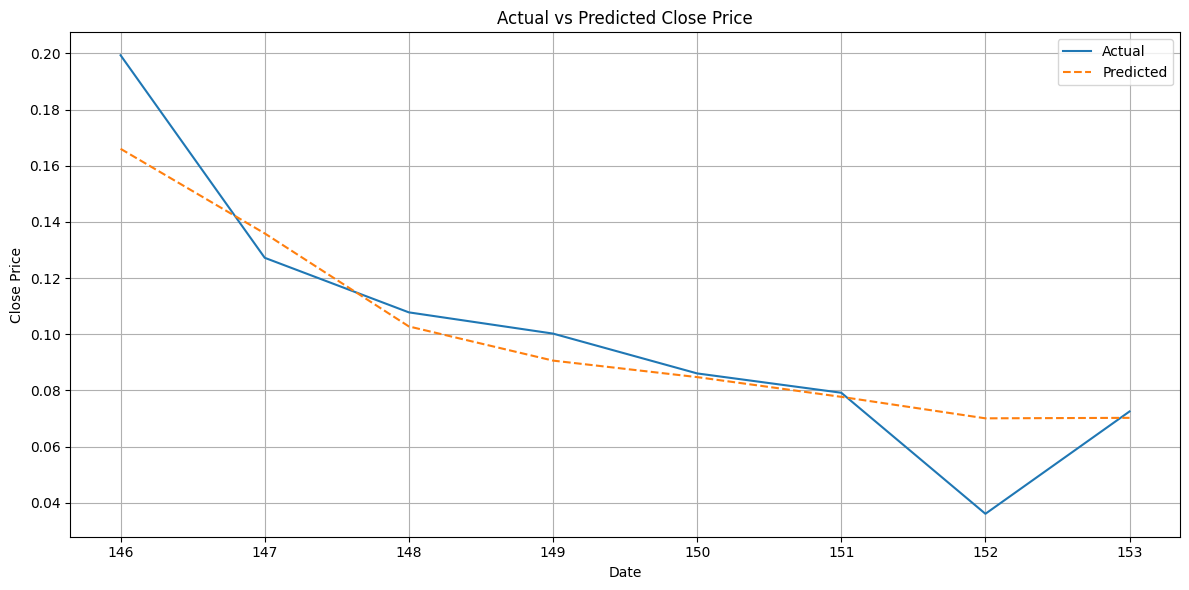

<Figure size 640x480 with 0 Axes>

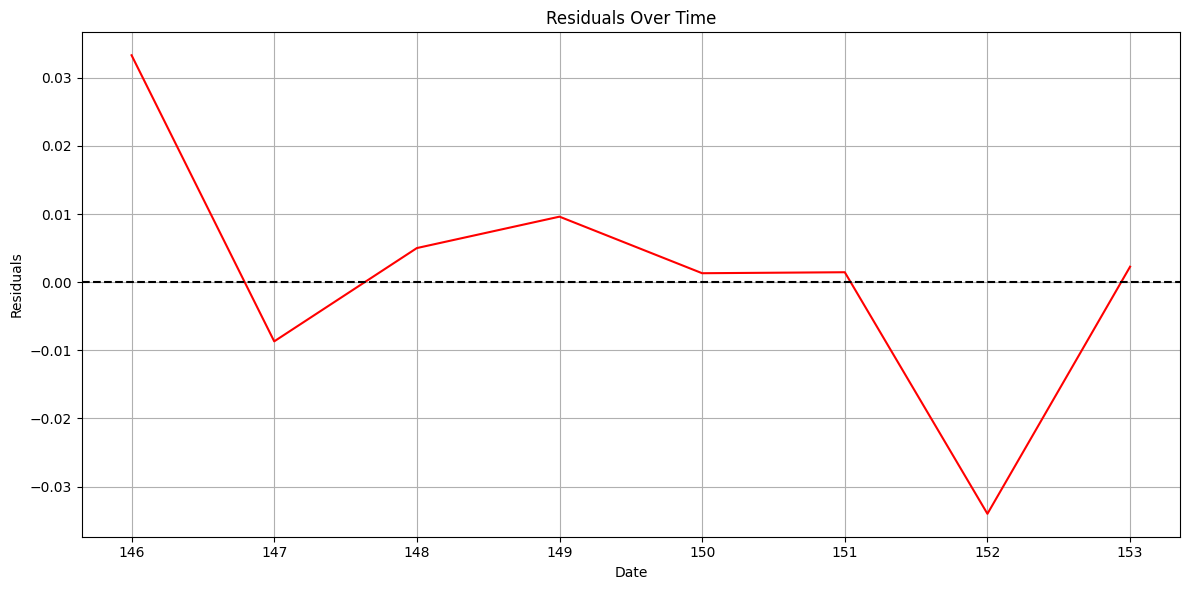

<Figure size 640x480 with 0 Axes>

In [ ]:
#predicting using the trained model
y_pred_2 = model_best_2.predict(X_2)

#plot
plt.figure(figsize=(12, 6))
plt.plot(X_2.index, y_2, label='Actual', )
plt.plot(X_2.index, y_pred_2, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#save image
plt.savefig('actual_vs_predicted_df_2.png')

#residuals
residuals = y_2 - y_pred_2
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('residuals_df_2.png')


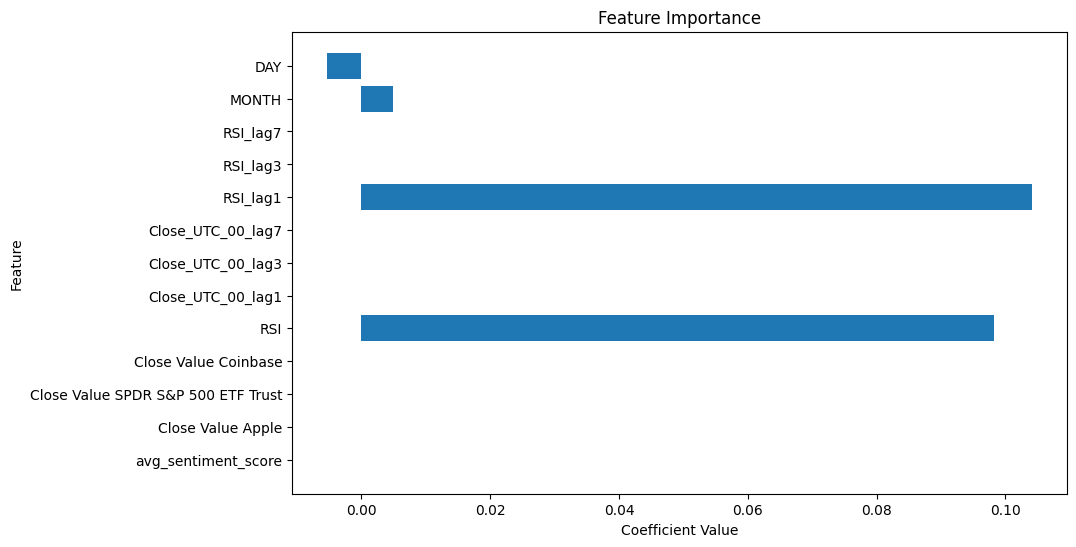

<Figure size 640x480 with 0 Axes>

In [ ]:
#feature importance
feature_importance = pd.DataFrame({
    'Feature': X_2.columns[1:],
    'Coefficient': model_best_2.params[1:]
})

#plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()
plt.savefig('feature_importance_df_2.png')

In [ ]:
tracker.stop()
#saving everything created into zip file, including model, results and images and emmisions
with zipfile.ZipFile('results_lin_reg.zip', 'w') as zipf:
    zipf.write('results_df_1.csv')
    zipf.write('results_df_2.csv')
    zipf.write('actual_vs_predicted_df_1.png')
    zipf.write('actual_vs_predicted_df_2.png')
    zipf.write('residuals_df_1.png')
    zipf.write('residuals_df_2.png')
    zipf.write('feature_importance_df_1.png')
    zipf.write('feature_importance_df_2.png')
    zipf.write('best_model_df_1.pkl')
    zipf.write('best_model_df_2.pkl')
    zipf.write('emissions_lin_reg.csv')

files.download('results_lin_reg.zip')


[codecarbon INFO @ 23:55:54] Energy consumed for RAM : 0.001239 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:55:54] Delta energy consumed for CPU with constant : 0.000131 kWh, power : 42.5 W
[codecarbon INFO @ 23:55:54] Energy consumed for All CPU : 0.005267 kWh
[codecarbon INFO @ 23:55:54] 0.006506 kWh of electricity used since the beginning.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Appendix

## Model 1: Sentiment + Apple + Coinbase
Code
```
y1 = df['Close_UTC_00']
X1 = df[['avg_sentiment_score', 'Close Value Apple', 'Close Value Coinbase']]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y1, X1).fit()
print("\nModel 1: Twitter Sentiment + Apple and Coinbase")
print(model1.summary())
```
```
Model 1: Twitter Sentiment + Apple and Coinbase
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Close_UTC_00   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     428.8
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           6.39e-78
Time:                        15:53:27   Log-Likelihood:                 296.24
No. Observations:                 170   AIC:                            -584.5
Df Residuals:                     166   BIC:                            -571.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0560      0.020     -2.815      0.005      -0.095      -0.017
avg_sentiment_score      0.7846      0.104      7.559      0.000       0.580       0.990
Close Value Apple        0.6873      0.070      9.889      0.000       0.550       0.825
Close Value Coinbase     0.0914      0.035      2.610      0.010       0.022       0.161
==============================================================================
Omnibus:                        4.771   Durbin-Watson:                   0.736
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                4.842
Skew:                          -0.406   Prob(JB):                       0.0888
Kurtosis:                       2.849   Cond. No.                         37.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
```